# Cross Validation
As time-series have the inherent structure we could run into problems with traditional shuffled Kfolds cross-validation. hcrystalball implements forward rolling cross-validation making training set consist only of observations that occurred prior to the observations that form the test set.

<center><img src="../../../_static/FinerTimeSplit.svg"></center>

In [1]:
from hcrystalball.model_selection import FinerTimeSplit
from sklearn.model_selection import cross_validate
from hcrystalball.wrappers import ExponentialSmoothingWrapper

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 6]

In [3]:
from hcrystalball.utils import get_sales_data

df = get_sales_data(n_dates=100, 
                    n_assortments=1,
                    n_states=1, 
                    n_stores=1)
X, y = pd.DataFrame(index=df.index), df['Sales']

## Native Cross Validation

In [4]:
cross_validate(ExponentialSmoothingWrapper(), 
               X, 
               y, 
               cv=FinerTimeSplit(horizon=5, n_splits=2), 
               scoring='neg_mean_absolute_error')

{'fit_time': array([0.01100016, 0.00534296]),
 'score_time': array([0.00643301, 0.00403714]),
 'test_score': array([-4822.46061508, -5489.06393347])}

## Grid search and model selection

Model selection and parameter tuning is the area where hcrystalball really shines. There is ongoing and probably a never-ending discussion about superiority or inferiority of ML techniques over common statistical/econometrical ones. Why not try both? The problem of a simple comparison between the performance of different kind of algorithms such as SARIMAX, Prophet, regularized linear models, and XGBoost lead to hcrystalball. Let's see how to do it!

In [5]:
from hcrystalball.compose import TSColumnTransformer
from hcrystalball.feature_extraction import SeasonalityTransformer
from hcrystalball.wrappers import ProphetWrapper
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from hcrystalball.wrappers import SarimaxWrapper
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

### Define our pipeline

In [6]:
sklearn_model_pipeline = Pipeline([
    ('seasonality', SeasonalityTransformer(freq='D')),
    ('model', 'passthrough') # this will be overwritten by param grid
]) 

### Define pipeline parameters including different models

In [7]:
param_grid = [{'model': [sklearn_model_pipeline],
               'model__model':[get_sklearn_wrapper(RandomForestRegressor), 
                               get_sklearn_wrapper(LinearRegression)]},
              {'model': [ProphetWrapper()],
               'model__seasonality_mode':['multiplicative', 'additive']},
              {'model': [SarimaxWrapper(order=(2,1,1), suppress_warnings=True)]}
             ]

### Run native grid search

In [8]:
grid_search = GridSearchCV(estimator=sklearn_model_pipeline, 
                           param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=FinerTimeSplit(horizon=5, n_splits=2),
                           refit=False, 
                           error_score=np.nan) 

In [9]:
results = grid_search.fit(X, y)

In [10]:
pd.DataFrame(results.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__model,param_model__seasonality_mode,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
1,0.019943,0.002446,0.050979,0.000094,"(SeasonalityTransformer(auto=True, freq='D', m...","SklearnWrapper(clip_predictions_lower=None, cl...",NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-1263.234636,-1466.042533,-1364.638585,101.403949,1
0,0.022864,0.002706,0.190258,0.011604,"(SeasonalityTransformer(auto=True, freq='D', m...","SklearnWrapper(bootstrap=True, ccp_alpha=0.0, ...",NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-1985.424000,-1729.036000,-1857.230000,128.194000,2
2,1.012166,0.622536,1.637623,0.076543,"ProphetWrapper(changepoint_prior_scale=0.05, c...",NaN,multiplicative,{'model': ProphetWrapper(changepoint_prior_sca...,-2601.205624,-1407.257183,-2004.231403,596.974220,3
3,0.497856,0.167629,2.964522,0.931830,"ProphetWrapper(changepoint_prior_scale=0.05, c...",NaN,additive,{'model': ProphetWrapper(changepoint_prior_sca...,-2687.583938,-1330.634452,-2009.109195,678.474743,4
4,1.286065,0.192093,0.025675,0.001419,"SarimaxWrapper(always_search_model=False, auto...",NaN,NaN,{'model': SarimaxWrapper(always_search_model=F...,-1121.756502,-14636.329690,-7879.043096,6757.286594,5


It seems that the best model is sklearn with RandomForestRegressor, but in time-series, it is often also a good idea to check how the forecasts look like. Unfortunately, this is not possible with sklearn. grid_search is returning just the results, not the predictions of individual models for different splits. hcrystalball thus implements special scoring functions that track all data from the grid_search.

## Custom scorer

In [11]:
from hcrystalball.metrics import make_ts_scorer
from sklearn.metrics import mean_absolute_error

In [12]:
scoring = make_ts_scorer(mean_absolute_error, 
                         greater_is_better=False)

In [13]:
grid_search = GridSearchCV(estimator=sklearn_model_pipeline, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           cv=FinerTimeSplit(horizon=5, n_splits=2),
                           refit=False, 
                           error_score=np.nan) 
results = grid_search.fit(X, y)

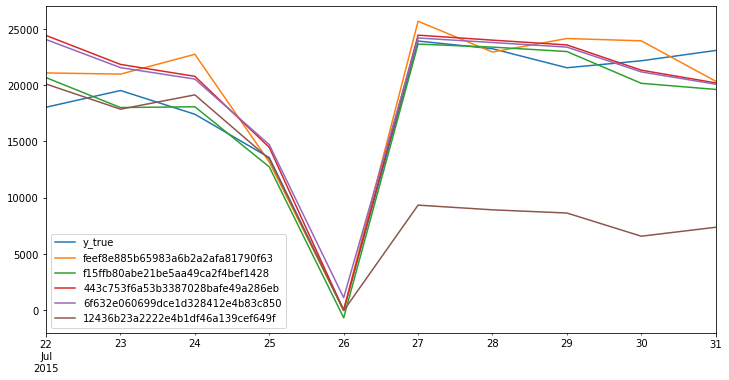

In [14]:
results.scorer_.cv_data.loc[:,lambda x: x.columns != 'split'].plot();

hcrystalball internally tracks data based on unique model hashes since model string represantations (reprs) are very long for usable columns names in dataframe, but if you are curious i.e. what was the worse model not to use it for further experiment, you can do it with scorers `estimator_ids` attribute

In [15]:
results.scorer_.cv_data.head()

,split,y_true,feef8e885b65983a6b2a2afa81790f63,f15ffb80abe21be5aa49ca2f4bef1428,443c753f6a53b3387028bafe49a286eb,6f632e060699dce1d328412e4b83c850,12436b23a2222e4b1df46a139cef649f
2015-07-22,0,18046.0,21096.67,20676.741135,24428.095232,24065.094696,20108.466066
2015-07-23,0,19532.0,20989.04,18015.494274,21852.187052,21566.265711,17871.044437
2015-07-24,0,17420.0,22755.20,18084.973453,20794.186776,20548.954160,19143.537103
2015-07-25,0,13558.0,13172.93,12739.066714,14475.237140,14713.923592,13445.105480
2015-07-26,0,0.0,0.00,-685.019580,-12.321919,1099.681531,-48.929259


We can get to the model definitions using hash in `results.scorer_.estimator_ids` dict